# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [8]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [9]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.shape

(891221, 85)

In [7]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [9]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [10]:
azdias.nunique()

AGER_TYP                    5
ALTERSKATEGORIE_GROB        5
ANREDE_KZ                   2
CJT_GESAMTTYP               6
FINANZ_MINIMALIST           5
FINANZ_SPARER               5
FINANZ_VORSORGER            5
FINANZ_ANLEGER              5
FINANZ_UNAUFFAELLIGER       5
FINANZ_HAUSBAUER            5
FINANZTYP                   6
GEBURTSJAHR               117
GFK_URLAUBERTYP            12
GREEN_AVANTGARDE            2
HEALTH_TYP                  4
LP_LEBENSPHASE_FEIN        41
LP_LEBENSPHASE_GROB        13
LP_FAMILIE_FEIN            12
LP_FAMILIE_GROB             6
LP_STATUS_FEIN             10
LP_STATUS_GROB              5
NATIONALITAET_KZ            4
PRAEGENDE_JUGENDJAHRE      16
RETOURTYP_BK_S              5
SEMIO_SOZ                   7
SEMIO_FAM                   7
SEMIO_REL                   7
SEMIO_MAT                   7
SEMIO_VERT                  7
SEMIO_LUST                  7
                         ... 
OST_WEST_KZ                 2
WOHNLAGE                    8
CAMEO_DEUG

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
# function that converts the missing vals to int if possible, otherwise it stays str
def parse_missing_string(s):
    try:
        return [int(x) for x in s.strip('[]').split(',')]
    except:
        return s.strip('[]').split(',')

In [9]:
# Use the function to create a column:fields map that we can use to replace
missing_map = feat_info.set_index('attribute').missing_or_unknown.apply(parse_missing_string).to_dict()

It's good to take a quick look at the missing map to make sure it's ok. Note that the empty strings are good here - they allow the replace function to work even though it won't map anything.

In [10]:
missing_map

{'AGER_TYP': [-1, 0],
 'ALTERSKATEGORIE_GROB': [-1, 0, 9],
 'ALTER_HH': [0],
 'ANREDE_KZ': [-1, 0],
 'ANZ_HAUSHALTE_AKTIV': [0],
 'ANZ_HH_TITEL': [''],
 'ANZ_PERSONEN': [''],
 'ANZ_TITEL': [''],
 'ARBEIT': [-1, 9],
 'BALLRAUM': [-1],
 'CAMEO_DEUG_2015': ['-1', 'X'],
 'CAMEO_DEU_2015': ['XX'],
 'CAMEO_INTL_2015': ['-1', 'XX'],
 'CJT_GESAMTTYP': [0],
 'EWDICHTE': [-1],
 'FINANZTYP': [-1],
 'FINANZ_ANLEGER': [-1],
 'FINANZ_HAUSBAUER': [-1],
 'FINANZ_MINIMALIST': [-1],
 'FINANZ_SPARER': [-1],
 'FINANZ_UNAUFFAELLIGER': [-1],
 'FINANZ_VORSORGER': [-1],
 'GEBAEUDETYP': [-1, 0],
 'GEBAEUDETYP_RASTER': [''],
 'GEBURTSJAHR': [0],
 'GFK_URLAUBERTYP': [''],
 'GREEN_AVANTGARDE': [''],
 'HEALTH_TYP': [-1, 0],
 'HH_EINKOMMEN_SCORE': [-1, 0],
 'INNENSTADT': [-1],
 'KBA05_ANTG1': [-1],
 'KBA05_ANTG2': [-1],
 'KBA05_ANTG3': [-1],
 'KBA05_ANTG4': [-1],
 'KBA05_BAUMAX': [-1, 0],
 'KBA05_GBZ': [-1, 0],
 'KBA13_ANZAHL_PKW': [''],
 'KKK': [-1, 0],
 'KK_KUNDENTYP': [-1],
 'KONSUMNAEHE': [''],
 'LP_FAMILIE_FEI

In [11]:
# create a new df with missing values replaced
demog = azdias.replace(missing_map, np.nan)

We can spot check a few columns to make sure it worked, it looks pretty good!

In [10]:
i=0

In [11]:
azdias.iloc[:, i].value_counts()

-1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64

In [12]:
demog.iloc[:, i].value_counts()

2.0    98472
1.0    79802
3.0    27104
Name: AGER_TYP, dtype: int64

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [12]:
# function that returns the percent of missing data in each column (axis=0) or row (axis=1)
def missing_percent(df, axis=0):
    return df.isnull().sum(axis=axis)/df.shape[axis]

We can use this function to check the missing amount relative to the overall count, spot check by looking at the first few columns:

In [13]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_percent(demog).head(20)

AGER_TYP                 0.769554
ALTERSKATEGORIE_GROB     0.003233
ANREDE_KZ                0.000000
CJT_GESAMTTYP            0.005446
FINANZ_MINIMALIST        0.000000
FINANZ_SPARER            0.000000
FINANZ_VORSORGER         0.000000
FINANZ_ANLEGER           0.000000
FINANZ_UNAUFFAELLIGER    0.000000
FINANZ_HAUSBAUER         0.000000
FINANZTYP                0.000000
GEBURTSJAHR              0.440203
GFK_URLAUBERTYP          0.005446
GREEN_AVANTGARDE         0.000000
HEALTH_TYP               0.124768
LP_LEBENSPHASE_FEIN      0.109549
LP_LEBENSPHASE_GROB      0.106115
LP_FAMILIE_FEIN          0.087287
LP_FAMILIE_GROB          0.087287
LP_STATUS_FEIN           0.005446
dtype: float64

Let's plot a histogram for both the percent and total number of missing rows:

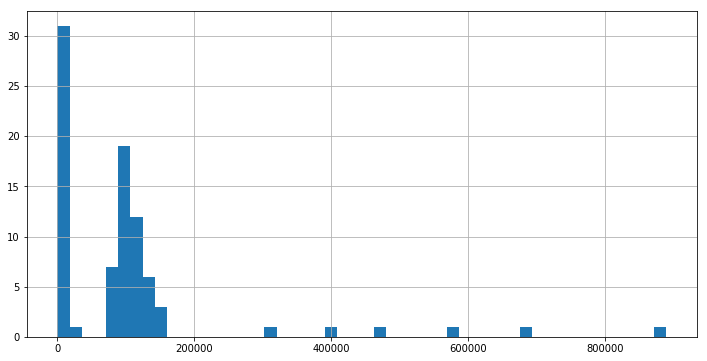

In [35]:
# Investigate patterns in the amount of missing data in each column.

demog.isnull().sum().hist(bins=50, figsize=(12, 6))

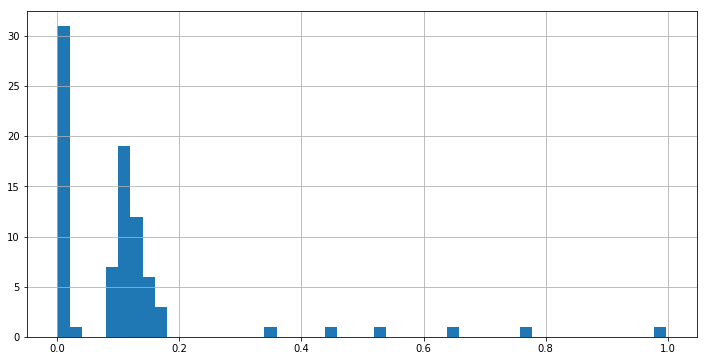

In [18]:
# Investigate patterns in the amount of missing data in each column.

missing_percent(demog).hist(bins=50, figsize=(12, 6))

It's clear that there are a few columns with way more data missing, let's check what the specific columns are that have >30% missing values:

In [21]:
outlier_columns = missing_percent(demog).where(missing_percent(demog) > 0.3).dropna()
outlier_columns

AGER_TYP        0.769554
GEBURTSJAHR     0.440203
TITEL_KZ        0.997576
ALTER_HH        0.348137
KK_KUNDENTYP    0.655967
KBA05_BAUMAX    0.534687
dtype: float64

We can just exclude those columns from the dataset.

In [27]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

demog.drop(outlier_columns.index, axis=1, inplace=True)

Taking a look at the distribution now, it's quite different:

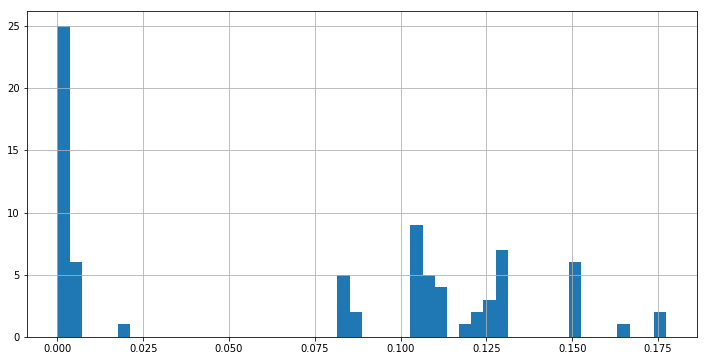

In [28]:
missing_percent(demog).hist(bins=50, figsize=(12, 6))

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

There are a few obvious matterns in the data missing from the demographic information - there are several columns that have a huge number of missing values (>30% of the records). I elected to just drop them from the dataset since they don't have much value and would make future work harder. The dropped columns were:

1. AGER_TYP: Best-ager typology

2. GEBURTSJAHR: Year of birth

3. TITEL_KZ: Academic title flag

4. ALTER_HH: Birthdate of head of household

5. KK_KUNDENTYP: Consumer pattern over past 12 months

6. KBA05_BAUMAX: Most common building type within the microcell


In the remaining columns, there are around 30 which have almost no missing values at all. In addition there are pockets of several columns each having different amounts of missing data ranging from ~7% to 17.5%. I've chosen to keep those in the dataset since they have information for very many samples

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [39]:
# we can use the function defined earlier to check missing values on a row basis
missing_percent(demog, axis=1).head(20)

0     0.544304
1     0.000000
2     0.000000
3     0.088608
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.594937
12    0.075949
13    0.101266
14    0.594937
15    0.101266
16    0.075949
17    0.594937
18    0.037975
19    0.000000
dtype: float64

We can do a similar approach to what we did for columns and check out the distribution of rows with missing data.

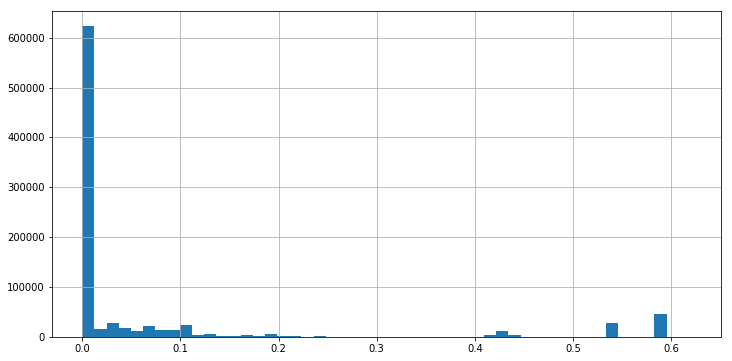

In [40]:
missing_percent(demog, axis=1).hist(bins=50, figsize=(12, 6))

Looks like there is a nice point to divide the dataset at 30% of data missing!

In [35]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

demog_low_missing = demog[missing_percent(demog, axis=1) <= 0.3]
demog_high_missing = demog[missing_percent(demog, axis=1) > 0.3]

Now we should check out the distribution of the low missing value group:

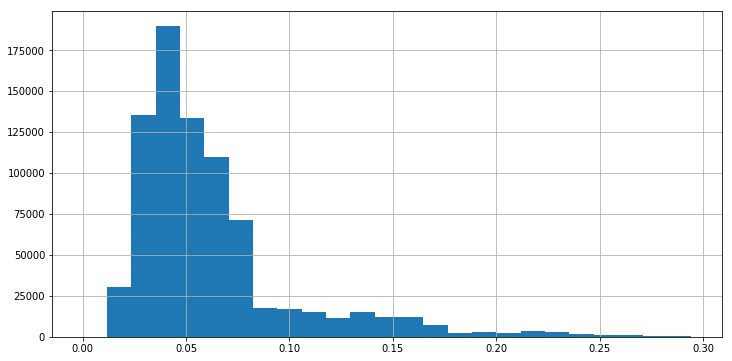

In [43]:
missing_percent(demog_low_missing, axis=1).hist(bins=25, figsize=(12, 6))

Looks pretty great! Just a long-ish tail on a normal distribution centered around 4% of data missing. Now we have to compare columns that exist in both high and low missing value datasets. To start we can find the columns that aren't missing any data in both sets and compare those.

In [36]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
missing_percent(demog_low_missing)[missing_percent(demog_high_missing)==0]

ANREDE_KZ                0.0
FINANZ_MINIMALIST        0.0
FINANZ_SPARER            0.0
FINANZ_VORSORGER         0.0
FINANZ_ANLEGER           0.0
FINANZ_UNAUFFAELLIGER    0.0
FINANZ_HAUSBAUER         0.0
FINANZTYP                0.0
GREEN_AVANTGARDE         0.0
SEMIO_SOZ                0.0
SEMIO_FAM                0.0
SEMIO_REL                0.0
SEMIO_MAT                0.0
SEMIO_VERT               0.0
SEMIO_LUST               0.0
SEMIO_ERL                0.0
SEMIO_KULT               0.0
SEMIO_RAT                0.0
SEMIO_KRIT               0.0
SEMIO_DOM                0.0
SEMIO_KAEM               0.0
SEMIO_PFLICHT            0.0
SEMIO_TRADV              0.0
ZABEOTYP                 0.0
dtype: float64

In [85]:
def compare_column(df_low, df_high, col):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    
    sns.countplot(x=col, data=df_low, ax=ax1)
    ax1.set_title('low missing')
    sns.countplot(x=col, data=df_high, ax=ax2)
    ax2.set_title('high missing')

We can go through the list and see if they are different.

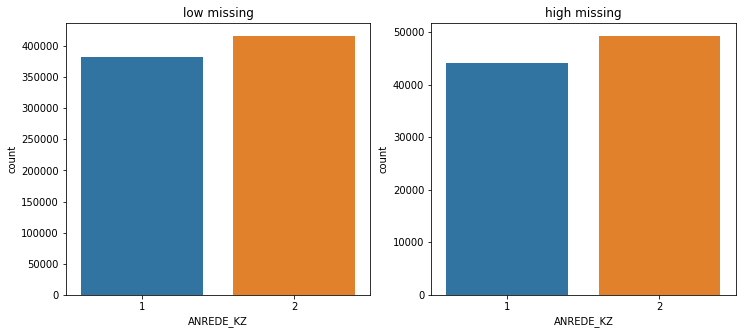

In [86]:
compare_column(demog_low_missing, demog_high_missing, 'ANREDE_KZ')

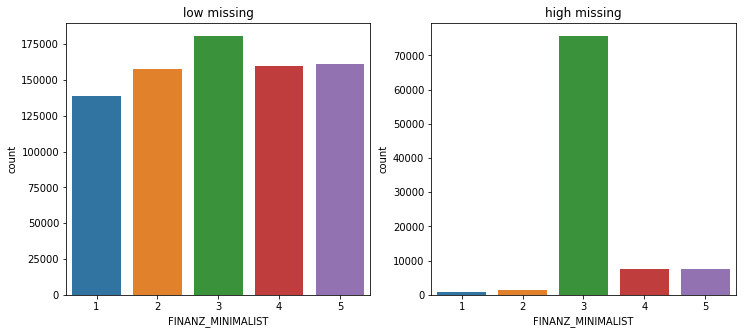

In [87]:
compare_column(demog_low_missing, demog_high_missing, 'FINANZ_MINIMALIST')

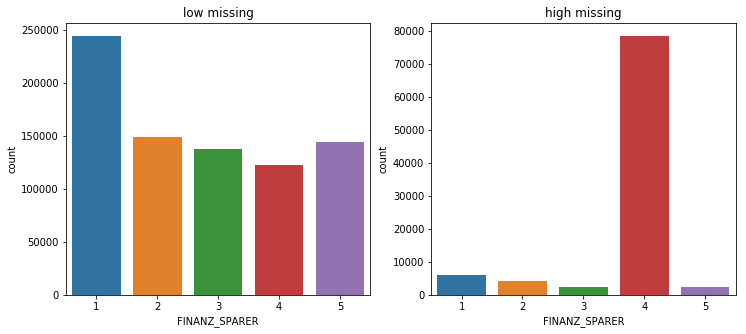

In [88]:
compare_column(demog_low_missing, demog_high_missing, 'FINANZ_SPARER')

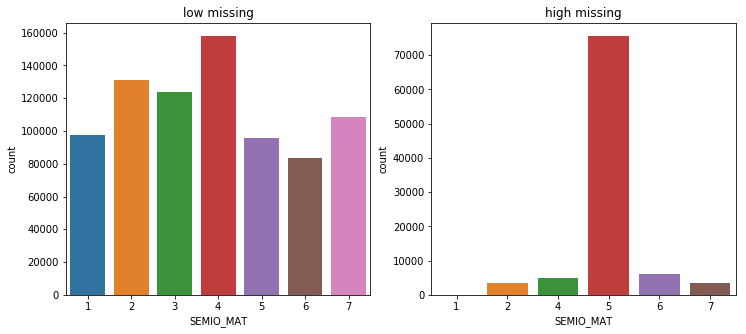

In [89]:
compare_column(demog_low_missing, demog_high_missing, 'SEMIO_MAT')

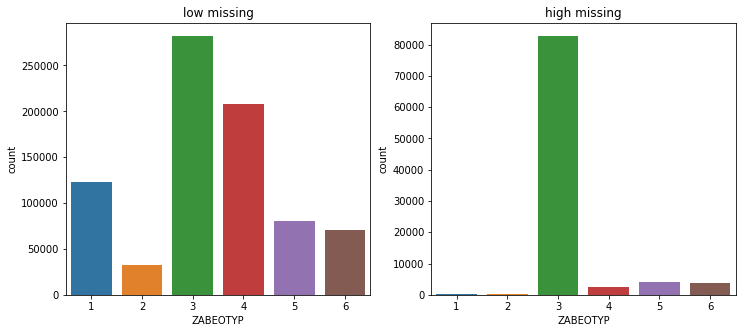

In [90]:
compare_column(demog_low_missing, demog_high_missing, 'ZABEOTYP')

In [169]:
# copy the low missing for future use, serves as a checkpoint in case stuff is messed up
demog_new = demog_low_missing.copy(deep=True)

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

We removed quite a few rows that had >30% of their values missing. It works out to just over 10% of the dataset that were in this regime. The rows in the high missing value group are going to be excluded from the pca and clustering analysis, but will have to be kept in mind later.

The high missing value rows do seem to have a **very** different distribution than the low missing values. This indicates that they likely are a qualitatively different group of people. We are going to exclude them from the clustering analysis but should compare the fraction of people in this high missing value group later on.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [93]:
# How many features are there of each data type?

feat_info.type.value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [126]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical_cols = feat_info[feat_info.type=='categorical'].attribute \
    .where(~categorical_cols.isin(outlier_columns.index)).dropna() # filter out the dropped columns

We can check the number of different values in each category pretty easily. We find that there are 5 with 2 categories and several with a really large number of categories.

In [150]:
demog_new[categorical_cols].nunique().sort_values()

ANREDE_KZ            2
OST_WEST_KZ          2
VERS_TYP             2
SOHO_KZ              2
GREEN_AVANTGARDE     2
NATIONALITAET_KZ     3
SHOPPER_TYP          4
LP_STATUS_GROB       5
LP_FAMILIE_GROB      5
FINANZTYP            6
ZABEOTYP             6
CJT_GESAMTTYP        6
GEBAEUDETYP          7
CAMEO_DEUG_2015      9
LP_STATUS_FEIN      10
LP_FAMILIE_FEIN     11
GFK_URLAUBERTYP     12
CAMEO_DEU_2015      44
dtype: int64

Turns out that OST_WEST_KZ has 'W' and 'O' instead of 0 and 1. We will re-encode it as 0 and 1.

In [151]:
demog_new.OST_WEST_KZ.value_counts()

W    629332
O    168505
Name: OST_WEST_KZ, dtype: int64

In [170]:
# Re-encode categorical variable(s) to be kept in the analysis.

demog_new.loc[:,'OST_WEST_KZ']=demog_new.OST_WEST_KZ.map({'W':0, 'O':1})

In [153]:
demog_new.OST_WEST_KZ.value_counts()

0    629332
1    168505
Name: OST_WEST_KZ, dtype: int64

I decided to drop features with more than 5 categories - this keeps some of the features without keeping the ones that would make the rest of the analysis really hard.

In [171]:
counts = demog_new[categorical_cols].nunique()

In [172]:
# extract columns with more than 5 values
multi_cat_columns = counts[counts > 5].index.values

In [173]:
demog_new.drop(multi_cat_columns, axis=1, inplace=True)

We can one hot encode the remaining columns with <=5 categories.

In [176]:
remaining_cols = ['NATIONALITAET_KZ',     
                  'SHOPPER_TYP',          
                  'LP_STATUS_GROB',      
                  'LP_FAMILIE_GROB']

In [182]:
# pandas.get_dummies is a really easy way to one hot encode
demog_new = pd.get_dummies(demog_new, columns=remaining_cols)

Spot checking a few rows this all looks great!

In [183]:
demog_new.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1,0,0,0,0,0,0,1,0,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,1,0,0,0,1,0,0,0,0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,1,0,0,0,0,0,0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,1,0,0,0,0,0,0,0,1
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,1,0,0,0,1,0,0,0,0
6,2.0,2,1,5,1,5,4,3,0,2.0,...,1,0,0,0,0,1,0,0,0,0
7,1.0,1,3,3,4,1,3,2,0,1.0,...,1,0,0,0,0,1,0,0,0,0
8,3.0,1,4,4,2,4,2,2,1,3.0,...,0,0,0,0,1,1,0,0,0,0
9,3.0,2,2,4,2,3,5,4,1,2.0,...,0,1,0,0,0,1,0,0,0,0
10,3.0,2,2,2,5,3,1,5,0,2.0,...,1,0,0,0,0,1,0,0,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

I made the decision to keep features with <=5 categories for ease of use. This also entailed re-encoding OST_WEST_KZ as numbers. I didn't want to include larger categorical features as it will make understanding the data very difficult later, but keeping a few with fewer features should still be ok.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [198]:
feat_info[feat_info.type=='mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


From the data dictionary:

PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

We can use this to make two python dictionaries to separate these features:

In [190]:
# -1 and 0 should be already removed earlier

# maps each decade starting at 40s=1 and ending at 90s=6
decade_map = {
    1:1,
    2:1,
    3:2,
    4:2,
    5:3,
    6:3,
    7:3,
    8:4,
    9:4,
    10:5,
    11:5,
    12:5,
    13:5,
    14:6,
    15:6
}

# maps values for each movement Mainstream=0, Avantgarde=1
movement_map = {
    1:0,
    2:1,
    3:0,
    4:1,
    5:0,
    6:1,
    7:1,
    8:0,
    9:1,
    10:0,
    11:1,
    12:0,
    13:1,
    14:0,
    15:1
}

Now we re-engineer these features:

In [195]:
demog_new['PRAEGENDE_JUGENDJAHRE_DECADE'] = demog_new.PRAEGENDE_JUGENDJAHRE.map(decade_map)
demog_new['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = demog_new.PRAEGENDE_JUGENDJAHRE.map(movement_map)

Spot checking, it looks good!

In [201]:
demog_new[['PRAEGENDE_JUGENDJAHRE_DECADE', 'PRAEGENDE_JUGENDJAHRE_MOVEMENT']].head(10)

,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT
1,6.0,0.0
2,6.0,1.0
3,4.0,0.0
4,4.0,0.0
5,2.0,0.0
6,5.0,0.0
7,4.0,0.0
8,5.0,1.0
9,6.0,1.0
10,2.0,0.0


Now we will move on to the next one. It's info from the data dictionary is:

CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

The -1 and XX values were already removed - we should be able to just split the first and second digit using some simple string functions.

In [235]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
demog_new['CAMEO_INTL_2015_0']=demog_new.CAMEO_INTL_2015.dropna().apply(lambda x: int(str(x)[0]))
demog_new['CAMEO_INTL_2015_1']=demog_new.CAMEO_INTL_2015.dropna().apply(lambda x: int(str(x)[1]))

Looks like it worked!

In [234]:
demog_new.CAMEO_INTL_2015_0.head()

1    1.0
2    4.0
3    2.0
4    3.0
5    4.0
Name: CAMEO_INTL_2015_0, dtype: float64

Now I'll drop the mixed features I decided not to use or have already encoded.

In [239]:
mix_to_drop = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB']
demog_new.drop(mix_to_drop, axis=1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

Two columns were transformed in accordance with their meaning. This was pretty easily done since the columns contained a few easily separable features:
- PRAEGENDE_JUGENDJAHRE
- CAMEO_INTL_2015

A few columns were just kept. These columns were very similar to ordinal columns which mapped the number of homes or families in an area. They were classified as mixed because there was a flag related to business or rural homes, but I didn't think this was significant enough to require dropping or re-engineering:
- WOHNLAGE 
- KBA05_BAUMAX 
- PLZ8_BAUMAX

Two mixed columns were dropped. After looking through the definition of these features in the data dictionary I did not find an easy way to split them into a small number of features.
- LP_LEBENSPHASE_FEIN
- LP_LEBENSPHASE_GROB

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

We can double check by looking at info to see if there are only numeric values and not too many missing values:

In [240]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

demog_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797837 entries, 1 to 891220
Data columns (total 83 columns):
ALTERSKATEGORIE_GROB              795037 non-null float64
ANREDE_KZ                         797837 non-null int64
FINANZ_MINIMALIST                 797837 non-null int64
FINANZ_SPARER                     797837 non-null int64
FINANZ_VORSORGER                  797837 non-null int64
FINANZ_ANLEGER                    797837 non-null int64
FINANZ_UNAUFFAELLIGER             797837 non-null int64
FINANZ_HAUSBAUER                  797837 non-null int64
GREEN_AVANTGARDE                  797837 non-null int64
HEALTH_TYP                        761193 non-null float64
RETOURTYP_BK_S                    793171 non-null float64
SEMIO_SOZ                         797837 non-null int64
SEMIO_FAM                         797837 non-null int64
SEMIO_REL                         797837 non-null int64
SEMIO_MAT                         797837 non-null int64
SEMIO_VERT                        797837 no

In [38]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# We shouldn't have to do anything, we are all good!

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

I copied these functions down here since they come in handy for the clean data function! Everything gets used within the function so it makes sense to consolidate it again.

In [11]:
def parse_missing_string(s):
    try:
        return [int(x) for x in s.strip('[]').split(',')]
    except:
        return s.strip('[]').split(',')

In [12]:
missing_map = feat_info.set_index('attribute').missing_or_unknown.apply(parse_missing_string).to_dict()

In [13]:
def missing_percent(df, axis=0):
    return df.isnull().sum(axis=axis)/df.shape[axis]

In [14]:
# maps each decade starting at 40s=1 and ending at 90s=6
decade_map = {
    1:1,
    2:1,
    3:2,
    4:2,
    5:3,
    6:3,
    7:3,
    8:4,
    9:4,
    10:5,
    11:5,
    12:5,
    13:5,
    14:6,
    15:6
}

# maps values for each movement Mainstream=0, Avantgarde=1
movement_map = {
    1:0,
    2:1,
    3:0,
    4:1,
    5:0,
    6:1,
    7:1,
    8:0,
    9:1,
    10:0,
    11:1,
    12:0,
    13:1,
    14:0,
    15:1
}

In [15]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    print('Data cleaning starting, initially there are {} missing values.'.format(df.isnull().sum().sum()))
    
    # convert missing value codes into NaNs, ...
    print('Converting missing values to NaN via missing map.')
    res = df.replace(missing_map, np.nan)
    print('Total NaN count is now {}.'.format(res.isnull().sum().sum()))
    
    ############################################
    # remove selected columns and rows, ...
    
    # remove a hardcoded list of columns, I don't want the available columns to be tied to missing values
    many_nan_cols = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    print('Dropping columns found to have a high number of NaN:')
    print(many_nan_cols)
    print()
    
    res.drop(many_nan_cols, axis=1, inplace=True)
    
    # Check what fraction of the dataset is high NaN
    print('Removing rows with a high number of NaN values.')
    res_high = res[missing_percent(res, axis=1) > 0.3]
    print('Removed {} rows, {} percent of the dataset'.format(res_high.shape[0], 
                                                              round(100*res_high.shape[0]/res.shape[0],1)))
    # extract the low NaN rows to move forward
    res = res[missing_percent(res, axis=1) <= 0.3]
    print()
    #############################################
    # select, re-encode, and engineer column values.
    print('Performing feature encoding')
    
    # re-encode the binary column
    res.loc[:,'OST_WEST_KZ']=res.OST_WEST_KZ.map({'W':0, 'O':1})
    
    # one hot encode categorical cols with <= 5 categories
    ohe_cols = ['NATIONALITAET_KZ', 'SHOPPER_TYP', 'LP_STATUS_GROB', 'LP_FAMILIE_GROB']
    print('Encoding columns:')
    print(ohe_cols)
    res = pd.get_dummies(res, columns=ohe_cols)
    
    # drop columns for categorical features with >=6 categories
    print('Dropping hard to use multi category columns:')
    drop_multi_cat_cols = ['FINANZTYP', 'ZABEOTYP', 'CJT_GESAMTTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015',     
                            'LP_STATUS_FEIN', 'LP_FAMILIE_FEIN',  'GFK_URLAUBERTYP', 'CAMEO_DEU_2015']
    print(drop_multi_cat_cols)
    res.drop(drop_multi_cat_cols, axis=1, inplace=True)
    
    print()
    # Engineer mixed features
    print('Handling mixed features.')
    res['PRAEGENDE_JUGENDJAHRE_DECADE'] = res.PRAEGENDE_JUGENDJAHRE.map(decade_map)
    res['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = res.PRAEGENDE_JUGENDJAHRE.map(movement_map)
    
    res['CAMEO_INTL_2015_0']=res.CAMEO_INTL_2015.dropna().apply(lambda x: int(str(x)[0]))
    res['CAMEO_INTL_2015_1']=res.CAMEO_INTL_2015.dropna().apply(lambda x: int(str(x)[1]))
    
    # Drop mixed features
    print('Dropping encoded or hard to use mixed features:')
    mix_to_drop = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB']
    print(mix_to_drop)
    res.drop(mix_to_drop, axis=1, inplace=True)
    
    ##############################################
    print()
    # Return the cleaned dataframe.
    print('Done!')
    return res
    

Let's check that it works!

In [16]:
demographics = clean_data(azdias)

Data cleaning starting, initially there are 4896838 missing values.
Converting missing values to NaN via missing map.
Total NaN count is now 8373929.
Dropping columns found to have a high number of NaN:
['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']

Removing rows with a high number of NaN values.
Removed 93384 rows, 10.5 percent of the dataset

Performing feature encoding
Encoding columns:
['NATIONALITAET_KZ', 'SHOPPER_TYP', 'LP_STATUS_GROB', 'LP_FAMILIE_GROB']
Dropping hard to usemulti category columns:
['FINANZTYP', 'ZABEOTYP', 'CJT_GESAMTTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'LP_STATUS_FEIN', 'LP_FAMILIE_FEIN', 'GFK_URLAUBERTYP', 'CAMEO_DEU_2015']

Handling mixed features.
Dropping encoded or hard to use mixed features:
['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB']

Done!


In [33]:
demographics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797384 entries, 1 to 891220
Data columns (total 83 columns):
ALTERSKATEGORIE_GROB              794599 non-null float64
ANREDE_KZ                         797384 non-null int64
FINANZ_MINIMALIST                 797384 non-null int64
FINANZ_SPARER                     797384 non-null int64
FINANZ_VORSORGER                  797384 non-null int64
FINANZ_ANLEGER                    797384 non-null int64
FINANZ_UNAUFFAELLIGER             797384 non-null int64
FINANZ_HAUSBAUER                  797384 non-null int64
GREEN_AVANTGARDE                  797384 non-null int64
HEALTH_TYP                        760957 non-null float64
RETOURTYP_BK_S                    792744 non-null float64
SEMIO_SOZ                         797384 non-null int64
SEMIO_FAM                         797384 non-null int64
SEMIO_REL                         797384 non-null int64
SEMIO_MAT                         797384 non-null int64
SEMIO_VERT                        797384 no

Looks pretty good! All numeric data types without many missing values. Time to move on to the rest of the project!

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

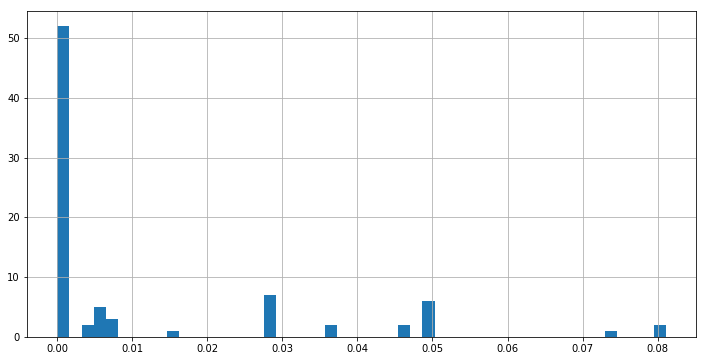

In [16]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
missing_percent(demographics).hist(bins=50, figsize=(12,6))

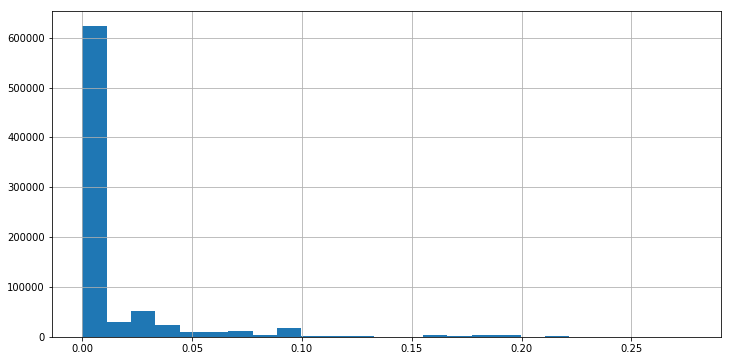

In [17]:
missing_percent(demographics, axis=1).hist(bins=25, figsize=(12,6))

In [17]:
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

imp = Imputer(strategy='most_frequent')
scaler = StandardScaler()

In [18]:
# Apply feature scaling to the general population demographics data.
X = imp.fit_transform(demographics)
X = scaler.fit_transform(X)

### Discussion 2.1: Apply Feature Scaling

After takng a look at the percent of missing values on a columns/rows basis, I decided to impute the missing values with the most_frequent instead of dropping rows with missing values. That would have cost us a pretty significant amount of the data. The most_frequent method was the best choice here since most of our data is oridinal or categorical rather than numeric in nature.

After than the data was scaled according to mean/stdev. This is good for clustering if all the features are of equal importance, it will give the most unbiased clustering. Improper scaling of features can lead to incorrect clustering if one feature has a much greater absolute value than others.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [19]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca_1 = PCA()
pca_1.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

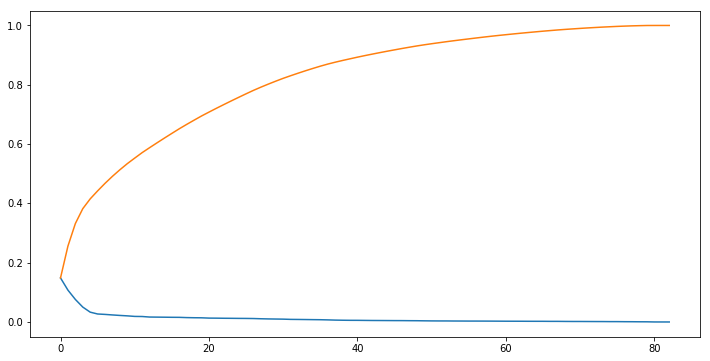

In [20]:
# Investigate the variance accounted for by each principal component.
plt.figure(figsize=(12,6))
plt.plot(pca_1.explained_variance_ratio_)
plt.plot(np.cumsum(pca_1.explained_variance_ratio_))

In [21]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=30)
X_reduced = pca.fit_transform(X)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

After doing PCA with no n_components it's not immedietely clear which number is the best to pick. There are clear diminishing returns but not a clear elbow point where most of the variance is explained. I chose to use 30 principle components because it will explain the majority of the variance with under half of the features.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [23]:
def component_features(i, columns, pca):
    components=pd.DataFrame(pca.components_)
    components.columns=columns
    return components.iloc[i,:].sort_values()

That function should be great for this purpose.

In [26]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
component_features(0, demographics.columns, pca)[:5]

PLZ8_ANTG1          -0.213673
MOBI_REGIO          -0.211646
KBA05_GBZ           -0.205079
FINANZ_MINIMALIST   -0.204396
KBA05_ANTG1         -0.201784
Name: 0, dtype: float64

In [28]:
component_features(0, demographics.columns, pca)[-5:]

HH_EINKOMMEN_SCORE    0.193834
PLZ8_BAUMAX           0.203582
PLZ8_ANTG4            0.207468
LP_STATUS_GROB_1.0    0.212326
PLZ8_ANTG3            0.213735
Name: 0, dtype: float64

Let's dive in to the first principle component. We see that it is strongly aligned with these features:

Negatively associated:
- PLZ8_ANTG1 Number of 1-2 family houses in the PLZ8 region (higher is more 1-2 family homes)
- MOBI_REGIO Movement patterns (higher means lower movement)
- KBA05_GBZ Number of buildings in the microcell (higher means more buildings)
- FINANZ_MINIMALIST Low financial interest (financial topology, one of five features. high/low here is the number of people with low financial interest)
- KBA05_ANTG1 Number of 1-2 family houses in the microcell (higher is more 1-2 family homes)

Positively associated:
- HH_EINKOMMEN_SCORE Estimated household net income (higher means lower income)
- PLZ8_BAUMAX Most common building type within the PLZ8 region (higher is more buildings or business flag)
- PLZ8_ANTG4 Number of 10+ family houses in the PLZ8 region (higher is more 10+ family homes)
- LP_STATUS_GROB_1.0 Categorical feature, 1 here is very low income earners
- PLZ8_ANTG3 Number of 6-10 family houses in the PLZ8 region (higher is more 6-10 family homes)

Taking a look at these features the first principle component seems to involve very heavily the population density and the economic well being of a region. Higher scores on this component are both more population dense and less well off.

In [29]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
component_features(1, demographics.columns, pca)[:5]

SEMIO_REL                      -0.260472
PRAEGENDE_JUGENDJAHRE_DECADE   -0.242427
FINANZ_SPARER                  -0.240340
SEMIO_PFLICHT                  -0.231672
SEMIO_TRADV                    -0.229945
Name: 1, dtype: float64

In [30]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
component_features(1, demographics.columns, pca)[-5:]

RETOURTYP_BK_S          0.157698
SEMIO_LUST              0.182694
SEMIO_ERL               0.232016
FINANZ_VORSORGER        0.232730
ALTERSKATEGORIE_GROB    0.261382
Name: 1, dtype: float64

Dive in to the second principle component

negative association
- SEMIO_REL Religious affinity (higher means lower religious association)
- PRAEGENDE_JUGENDJAHRE_DECADE constructed feature for birth decade (higher means later dominating movement)
- FINANZ_SPARER Financial topography, money-saver (higher means less association with money saving)
- SEMIO_PFLICHT Dutiful personality measure (higher means low affinity)
- SEMIO_TRADV traditional-minded personality measure (higher means low affinity)

positive association
- RETOURTYP_BK_S Return type (seems to be shopper type, higher is lower spending)
- SEMIO_LUST sensual-minded personality (higher means low affinity)
- SEMIO_ERL event-oriented personality (higher means low affinity)
- FINANZ_VORSORGER financial topography, prepared (higher means less association)
- ALTERSKATEGORIE_GROB Estimated age based on given name analysis (higher is older)

This features seems to combine both traditional / religion mindset in addition to age. The higher the feature the older, more traditionally minded, and better off financially the person is. Note that some of the features actually apply in the opposite direction as listed because a high value in that feature corresponds to LOW affinity.

In [31]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
component_features(2, demographics.columns, pca)[:5]

ANREDE_KZ    -0.356290
SEMIO_KAEM   -0.325953
SEMIO_DOM    -0.304123
SEMIO_KRIT   -0.268260
SEMIO_RAT    -0.211113
Name: 2, dtype: float64

In [32]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
component_features(2, demographics.columns, pca)[-5:]

FINANZ_MINIMALIST    0.151345
SEMIO_KULT           0.226372
SEMIO_FAM            0.241957
SEMIO_SOZ            0.256653
SEMIO_VERT           0.333955
Name: 2, dtype: float64

numero tres

negative association
- ANREDE_KZ Gender (1 male 2 female)
- SEMIO_KAEM combative attitude  personality (higher means low affinity)
- SEMIO_DOM dominant-minded  personality (higher means low affinity)
- SEMIO_KRIT critical-minded  personality (higher means low affinity)
- SEMIO_RAT rational  personality (higher means low affinity)

Positive association
- FINANZ_MINIMALIST Low financial interest (financial topology, one of five features. high/low here is the number of people with low financial interest)
- SEMIO_KULT cultural-minded  personality (higher means low affinity)
- SEMIO_FAM family-minded  personality (higher means low affinity)
- SEMIO_SOZ socially-minded  personality (higher means low affinity)
- SEMIO_VERT dreamful personality (higher means low affinity)

This feature takes into account gender (positive association should be male and negative negative) and other personality traits seem to line up with stereotypical gender roles. Family and socially minded individueals increase as this principle component decreases, while aggrresive and critical ideas increase as this component increases. 

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

Here I took a crack at intepreting the top 3 principle components. A more detailed analysis for each is above but the summary is:

1. Population of area (higher is higher) and financial well being (higher is worse)
2. Age and traditional/religious mindset (higher is older and more traditional)
3. Gender and family values (higher is aggressive and dominant and lower is family oriented)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [33]:
from sklearn.cluster import KMeans

In [37]:
scores=[]

# Over a number of different cluster counts...
for k in range(2, 31):
    
    model = KMeans(n_clusters=k)
    # run k-means clustering on the data and...
    model.fit(X_reduced)
    
    # compute the average within-cluster distances.
    scores.append(np.abs(model.score(X_reduced)))
    

In [72]:
print(scores)

[46336027.168361433, 43078031.351892456, 40719289.976073645, 38989576.933581196, 37629415.724720277, 36415327.87343663, 35491137.86688105, 34742182.25809484, 34114213.208011225, 33533648.744062219, 32926046.867110398, 32527903.333045673, 32160834.757564448, 31939839.97163194, 31377891.17347474, 30909899.035089198, 30535398.692706164, 30226560.328816574, 29980813.356498834, 30005493.148241565, 29589110.732568678, 29247769.987943523, 29061696.302388795, 28751897.109444775, 28477413.448690481, 28271237.796873793, 28050293.017858908, 27959721.640356708, 27794253.358362235]


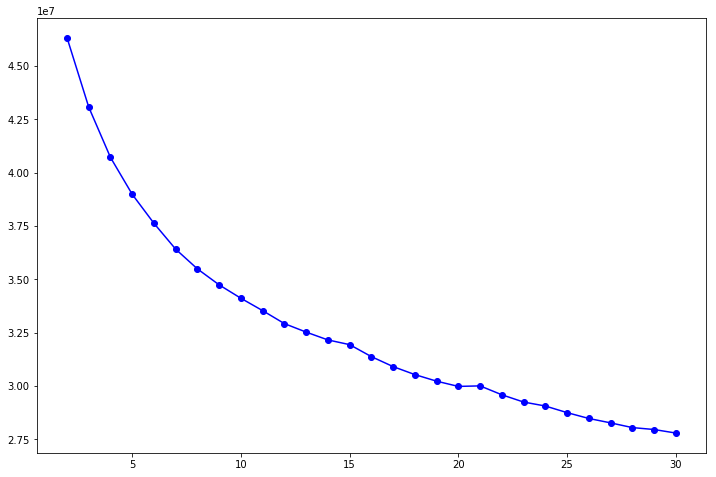

In [144]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(12,8))
plt.ylim=([0, 5e7])
plt.plot(range(2,31), scores, 'b-o')

In [73]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
model = KMeans(n_clusters=17)
model.fit(X_reduced)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=17, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [74]:
demographic_labels=model.predict(X_reduced)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

I ended up deciding on **17** clusters. Though there was no clear elbow point, there was clear diminishing returns in processing speed and efficiency as the number of clusters increased. I judged that a good number of clusters would be between 15-20 as it has lost a lot of the distance between the centroids but has only around half the number of the max that I tested.

I used the absolute value of the scikit-learn model scorer here - the model score is the negative of the sum of the distance to the centroids. They manually apply a negative in the function so that higher values are better, in our case making them positive is all we have to do to check out how the error relates to number of clusters!

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [77]:
# Load in the customer demographics data.
customers_raw = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

Let's apply our great cleaning function!

In [78]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers = clean_data(customers_raw)

Data cleaning starting, initially there are 2252274 missing values.
Converting missing values to NaN via missing map.
Total NaN count is now 3112918.
Dropping columns found to have a high number of NaN:
['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']

Removing rows with a high number of NaN values.
Removed 49962 rows, 26.1 percent of the dataset

Performing feature encoding
Encoding columns:
['NATIONALITAET_KZ', 'SHOPPER_TYP', 'LP_STATUS_GROB', 'LP_FAMILIE_GROB']
Dropping hard to usemulti category columns:
['FINANZTYP', 'ZABEOTYP', 'CJT_GESAMTTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'LP_STATUS_FEIN', 'LP_FAMILIE_FEIN', 'GFK_URLAUBERTYP', 'CAMEO_DEU_2015']

Handling mixed features.
Dropping encoded or hard to use mixed features:
['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB']

Done!


Everything looks great, time for transforms:

In [79]:
X_c = scaler.transform(imp.transform(customers))

In [80]:
X_c_reduced = pca.transform(X_c)

Now we just have to run the reduced data through the model:

In [81]:
customer_labels = model.predict(X_c_reduced)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [123]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

demographic_clusters = pd.Series(demographic_labels).value_counts().sort_index()
demographic_clusters[-1] = 93384
demographic_clusters.name = 'demographic'

Here we are creating some series that contain the percent of total in the group that each cluster occupies. We also add in a cluster '-1' for the rows that were removed earlier. 

In [124]:
customer_clusters = pd.Series(customer_labels).value_counts().sort_index()
customer_clusters[-1] = 49962
customer_clusters.name = 'customer'

We can check out the distribution of people over all the clusters and see where the big differences are!

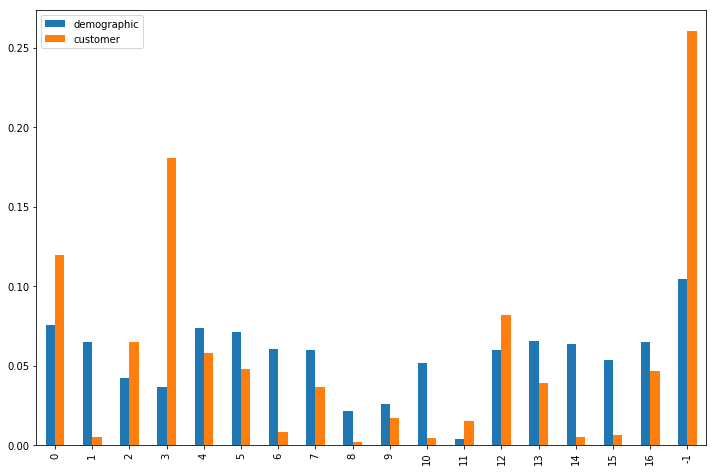

In [131]:
cluster_distribution = pd.concat([demographic_clusters / demographic_clusters.sum(),
                                  customer_clusters / customer_clusters.sum()],
                                 axis=1)
cluster_distribution.plot(kind='bar', figsize=(12,8))

Wow, it looks like there are some really big differences. Cluster 3 and -1 are both way more represented in the customers than in the overall demographics, and 0, 2, and 12 are slightly more represented.

1, 6, 14, and 15 are much less represented in the customers than in overall demographics.

First I'll take a look at cluster 3 and see what people are in that group. I'm going to take a look at that instead of group -1 because that one will be pretty hard to analyze and doesn't have the principle components.

In [139]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

demo_1 = pd.Series(demographic_labels)
demo_1.name='label'

demo = pd.concat([pd.DataFrame(X_reduced), demo_1], axis=1)
demo[demo.label==3].head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,label
15,-1.337126,0.989747,2.679691,4.330471,-1.941815,-0.202923,-1.097472,-0.800569,-0.456087,0.463357,...,1.146458,0.665085,1.209131,0.063376,0.851395,-0.155441,0.267457,-0.336641,-1.527768,3
83,-1.462255,1.712207,2.464319,1.781942,-0.530976,0.296857,0.633042,-0.822644,-0.552943,-0.751257,...,-0.854771,-0.407891,-0.630643,0.620177,-0.086835,-2.979741,-0.639883,-0.766873,-2.566828,3
87,-3.349216,0.739168,4.061411,1.960032,2.549654,-0.370530,-0.951143,1.438759,0.431606,-0.519056,...,-1.281681,-0.094710,0.064966,0.710267,-1.612626,-1.710572,-1.028742,-0.431076,-0.498889,3
98,-3.432138,0.215239,3.453895,3.728065,1.144537,-0.778395,-1.199140,0.376725,1.285512,-2.094628,...,-0.125292,0.841445,0.357095,-0.065723,-0.455835,0.615697,-0.121395,-0.111441,-1.418827,3
151,-6.043198,1.782014,2.650559,2.011971,-0.911566,0.423628,-0.838281,-0.228062,1.537994,-2.015342,...,-0.120088,-0.153567,-0.020880,0.080317,-0.798986,-0.099524,0.661505,0.570198,-0.337804,3


I put together this dataframe which is the principle components with a label column added. Let's take a look at the 3 cluster.

In [142]:
demo[demo.label==3].iloc[:, :5].describe()

,0,1,2,3,4
count,32538.000000,32538.000000,32538.000000,32538.000000,32538.000000
mean,-4.003115,1.293332,3.389706,2.395547,-0.430014
std,1.552213,1.081525,0.815191,1.204609,1.524480
min,-8.200967,-3.384726,0.332988,-2.043428,-5.148200
25%,-5.155190,0.563690,2.812162,1.583409,-1.560912
50%,-4.169749,1.292372,3.399830,2.440395,-0.494850
75%,-2.988901,2.036476,3.980304,3.249812,0.686166
max,1.351136,4.989615,6.130730,6.480660,4.931621


For this group taking a a look at the first principle components we find:

First component (0) is very negative. This indicates that the group is not living in high population density homes and areas and is doing well financially. 

Second component (1) is around 1 and has a large distribution. We probably capture people of all ages and mindsets, however it is slightly positive indicating a slight lean toward older people.

Third component (2) is again pretty positive. This indicates that we probably cater to males and more rational, combative thinkers. Less family oriented people.

Overall this means cluster three is probable a wide rande of economically well off people living in smaller households, possibly men.

Now we can take a look at cluster 14, one that is much heavier in the demographic than the customers data.

In [143]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

demo[demo.label==14].iloc[:, :5].describe()

,0,1,2,3,4
count,56718.000000,56718.000000,56718.000000,56718.000000,56718.000000
mean,2.412210,-1.760404,-2.847401,-0.046614,-0.794107
std,1.307578,1.334792,1.003197,1.442153,1.506850
min,-1.545882,-5.590643,-5.443898,-4.509206,-5.379865
25%,1.406882,-2.745598,-3.527645,-1.012552,-1.879563
50%,2.416805,-1.943693,-3.015866,-0.125515,-0.988743
75%,3.425924,-0.860913,-2.367320,0.767217,0.224398
max,6.073323,2.252187,1.162910,7.293136,5.066472


In cluster 14 we see a very different group from cluster 3.

First component (0): Generally positive indicating higher population density, more people per home, and lower income. The people in this group are probably living in lower income urban environments.

Second component (1). Here we have negative values, again contrasting the other cluster. This means we probably have a lean toward younger, more progressive people in this group. That also tends to correlate with worse financial situation.

Third component (2) overwhelmingly negative. That means we have more family oriented people here, possible more females.

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

You can definitely see some patterns in which clusters support and don't support our business. This analysis can be extremely powerful in identifying customer segments, this is just a quick first pass. There could easily be weeks spend on this small segment of this dataset alone. 

Already using just the first three principle components we are able to segment people by age, gender, financial situation, and population density. Different clusters have clearly different values in these principle components. Although we didn't dive too deeply into each cluster or component, if I were working at a company I would try to really investigate and understand what each group really means. That would probably take weeks of just digging through the features and the data.

I really enjoyed this project. Working with real data is always a challenge but this framework made it easy to follow. I love that there were pretty good results at the end, even with such a noisy dataset! I look forward to working with more data of this type in the future.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.